## Import packages

In [1]:
import osmnx as ox, networkx as nx, numpy as np, pandas as pd, geopandas as gpd, random, math
import matplotlib.pyplot as plt, matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.ops import transform
from scipy.spatial import cKDTree
from itertools import cycle
from pathlib import Path
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pyproj
import folium
from folium import GeoJson, CircleMarker, Marker, PolyLine, Icon, DivIcon
from folium.plugins import MarkerCluster
from matplotlib.lines import Line2D

## Load data

In [2]:
def cargar_geojson(nombre_archivo, directorio_base='../../../../data/delivetter'):
    """
    Carga un archivo GeoJSON específico y devuelve un GeoDataFrame.
    
    Args:
        nombre_archivo (str): Nombre del archivo GeoJSON (ej. 'barris.geojson').
        directorio_base (str): Ruta relativa al directorio donde se encuentra el archivo.
                              Por defecto: '../../data/delivetter'.
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con los datos del archivo.
        None: Si el archivo no existe o hay un error.
    """
    try:
        ruta = Path(directorio_base) / nombre_archivo
        
        if not ruta.exists():
            raise FileNotFoundError(f"File not found: {ruta.absolute()}")
        
        gdf = gpd.read_file(ruta)
        print(f"✅ '{nombre_archivo}' successfully loaded ({len(gdf)} records)")
        return gdf
    
    except Exception as e:
        print(f"❌ Error loading '{nombre_archivo}': {str(e)}")
        return None
    
barrios = cargar_geojson('barris.geojson')
catastro = cargar_geojson('catastro.geojson')
puntos_carga = cargar_geojson('puntosCID.geojson')

✅ 'barris.geojson' successfully loaded (88 records)
✅ 'catastro.geojson' successfully loaded (36346 records)
✅ 'puntosCID.geojson' successfully loaded (885 records)


## Graph request 

### 🏙️ NEIGHBORHOODS WITH AT LEAST ONE CiD POINT

| AIORA                | ARRANCAPINS          | BENICALAP               | BENIFERRI                |
|----------------------|----------------------|--------------------------|--------------------------|
| BENIFARAIG           | BENIMACLET           | BENIMAMET               | CABANYAL-CANYAMELAR      |
| CAMI DE VERA         | CAMI FONDO           | CAMI REAL               | CAMPANAR                 |
| CASTELLAR-L'OLIVERAL | CIUTAT DE LES ARTS I DE LES CIENCIES | CIUTAT FALLERA | CIUTAT JARDI             |
| CIUTAT UNIVERSITARIA | EL BOTANIC           | EL CALVARI              | EL FORN D'ALCEDO         |
| EL GRAU              | EL MERCAT            | EL PALMAR               | EL PERELLONET            |
| EL PLA DEL REMEI     | EN CORTS             | EXPOSICIO               | FAVARA                   |
| JAUME ROIG           | LA CARRASCA          | LA CREU COBERTA         | LA CREU DEL GRAU         |
| LA FONTETA S.LLUIS   | LA FONTSANTA         | LA GRAN VIA             | LA LLUM                  |
| LA MALVA-ROSA        | LA PETXINA           | LA PUNTA                | LA RAIOSA                |
| LA ROQUETA           | LA SEU               | LA TORRE                | LA VEGA BAIXA            |
| LES TENDETES         | L'HORT DE SENABRE    | L'ILLA PERDUDA          | L'AMISTAT                |
| MALILLA              | MARXALENES           | MASSARROJOS             | MESTALLA                 |
| MONTOLIVET           | MORVEDRE             | NATZARET                | NOU MOLES                |
| PATRAIX              | PENYA-ROJA           | PINEDO                  | RUSSAFA                  |
| SAFRANAR             | SANT ANTONI          | SANT FRANCESC           | SANT ISIDRE              |
| SANT LLORENS         | SANT MARCEL.LI       | SANT PAU                | SOTERNES                 |
| TORMOS               | TORREFIEL            | TRINITAT                | TRES FORQUES             |
| VARA DE QUART        | ALBORS               | BETERO                  |                          |



In [3]:
def get_graph(request):
    shp_neighbourhood = barrios[barrios["nombre"].str.strip().str.upper() == request.strip().upper()]
    if len(shp_neighbourhood) != 1:
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.strip().str.upper() == request.strip().upper()]
        if len(shp_neighbourhood) == 1:
            break
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]

    barrio = shp_neighbourhood["nombre"].values[0]
    shp_zone = shp_neighbourhood.geometry.values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    shp_bajos = catastro[catastro.intersects(shp_zone)]

    G = ox.graph_from_polygon(
        shp_zone,
        network_type="all_public",
        simplify=False,
        retain_all=False,
        truncate_by_edge=True
    )

    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps', 'service']
    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street', 'primary_link', 'primary', 'tertiary', 'trunk', 'service', 'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    allowed_pedestrian = ['pedestrian', 'footway', 'path', 'track', 'bridleway', 'living_street', 'residential']

    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True)
                       if data.get('highway') in not_highway or data.get('access') in ['private', 'no', 'customers']]
    G.remove_edges_from(edges_to_remove)

    G_vehicle = G.copy()
    G_pedestrian = G.copy()

    edges_to_remove_vehicle = [(u, v, k) for u, v, k, data in G_vehicle.edges(keys=True, data=True)
                                if data.get('highway') not in allowed_vehicle]
    G_vehicle.remove_edges_from(edges_to_remove_vehicle)

    edges_to_remove_pedestrian = [(u, v, k) for u, v, k, data in G_pedestrian.edges(keys=True, data=True)
                                  if data.get('highway') not in allowed_pedestrian]
    G_pedestrian.remove_edges_from(edges_to_remove_pedestrian)

    for graph in [G_vehicle, G_pedestrian]:
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) == 0]
        graph.remove_nodes_from(nodes_to_remove)

    G_vehicle = G_vehicle.subgraph(max(nx.weakly_connected_components(G_vehicle), key=len)).copy()
    G_pedestrian = G_pedestrian.subgraph(max(nx.weakly_connected_components(G_pedestrian), key=len)).copy()

    print(f"Graph for {barrio}:")
    print(f"Vehicle graph: {len(G_vehicle.nodes)} nodes, {len(G_vehicle.edges)} edges")
    print(f"Pedestrian graph: {len(G_pedestrian.nodes)} nodes, {len(G_pedestrian.edges)} edges")
    print(f"Loading points: {len(shp_loading_points)} points")
    print(f"Warehouse and store: {len(shp_bajos)} points")

    return barrio, G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos

def graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, bajos):
    # --- 1. Visualización de grafos en matplotlib ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    ox.plot_graph(G_vehicle, ax=axes[0], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='blue', bgcolor="white", show=False)
    axes[0].set_title("Drive graph")

    ox.plot_graph(G_pedestrian, ax=axes[1], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='red', bgcolor="white", show=False)
    axes[1].set_title("Pedestrian graph")
    plt.tight_layout()
    plt.show()

    # --- 2. Mapa interactivo en Folium ---

    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)

    gdf_edges_vehicle = ox.graph_to_gdfs(G_vehicle, nodes=False, edges=True)
    gdf_edges_pedestrian = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)

    bajos_in_zone = bajos[bajos.intersects(shp_zone)]

    # --- 2.1 Añadir zona del barrio ---
    folium.GeoJson(
        shp_zone,
        style_function=lambda feature: {
            "color": "limegreen", "weight": 6, "fill": True,
            "fillColor": "limegreen", "fillOpacity": 0.2
        }
    ).add_to(mapa)

    # --- 2.2 Función para añadir aristas ---
    def add_edges(gdf_edges, color, group_name):
        for _, row in gdf_edges.iterrows():
            if row.geometry.geom_type == "LineString":
                tooltip = folium.Tooltip(
                    f"<b>Type:</b> {row.get('highway', 'N/A')}<br>"
                    f"<b>Name:</b> {row.get('name', 'No name')}<br>"
                    f"<b>Length:</b> {round(row.get('length', 0), 1)} m"
                )
                folium.GeoJson(
                    row.geometry,
                    name=group_name,
                    style_function=lambda feature, col=color: {'color': col, 'weight': 2, 'opacity': 1},
                    tooltip=tooltip
                ).add_to(mapa)

    add_edges(gdf_edges_pedestrian, "red", "Pedestrians")
    add_edges(gdf_edges_vehicle, "blue", "Vehicles")

    # --- 2.3 Añadir puntos de carga ---
    for _, row in shp_loading_points.iterrows():
        folium.CircleMarker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            radius=6, color="black", fill=True, fill_color="orange", fill_opacity=1,
            popup=row.get("NOMBRE", "Loading Point")
        ).add_to(mapa)

    # --- 2.4 Añadir puntos bajos (almacenes y comercios) ---
    for _, row in bajos_in_zone.iterrows():
        if not row['Almacen'] and not row['Comercio']:
            continue
        centroide = row.geometry.centroid
        if row['Almacen'] and row['Comercio']:
            fill_color, label = 'black', 'Warehouse & Store'
        elif row['Almacen']:
            fill_color, label = 'purple', 'Warehouse'
        else:
            fill_color, label = 'lightblue', 'Store'
        folium.CircleMarker(
            location=[centroide.y, centroide.x],
            radius=6, color='black', fill=True, fill_color=fill_color, fill_opacity=1,
            popup=label
        ).add_to(mapa)

    # --- 2.5 Añadir leyenda personalizada ---
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: 140px;
                background-color: white; z-index:9999; font-size:13px; border:1px solid grey; 
                border-radius: 5px; padding: 8px; box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
        <b style="font-size:14px;">Legend</b><br>
        <i class="fa fa-circle" style="color:black; margin-right:5px;"></i> Warehouse & Store<br>
        <i class="fa fa-circle" style="color:orange; margin-right:5px;"></i> CiD Point<br>
        <i class="fa fa-circle" style="color:purple; margin-right:5px;"></i> Warehouse<br>
        <i class="fa fa-circle" style="color:lightblue; margin-right:5px;"></i> Store (delivery)<br>
        <i class="fa fa-square" style="color:limegreen; margin-right:5px;"></i> Neighborhood Boundary
    </div>'''
    mapa.get_root().html.add_child(folium.Element(legend_html))

    return mapa



Graph for SANT FRANCESC:
Vehicle graph: 427 nodes, 466 edges
Pedestrian graph: 1315 nodes, 2850 edges
Loading points: 13 points
Warehouse and store: 511 points


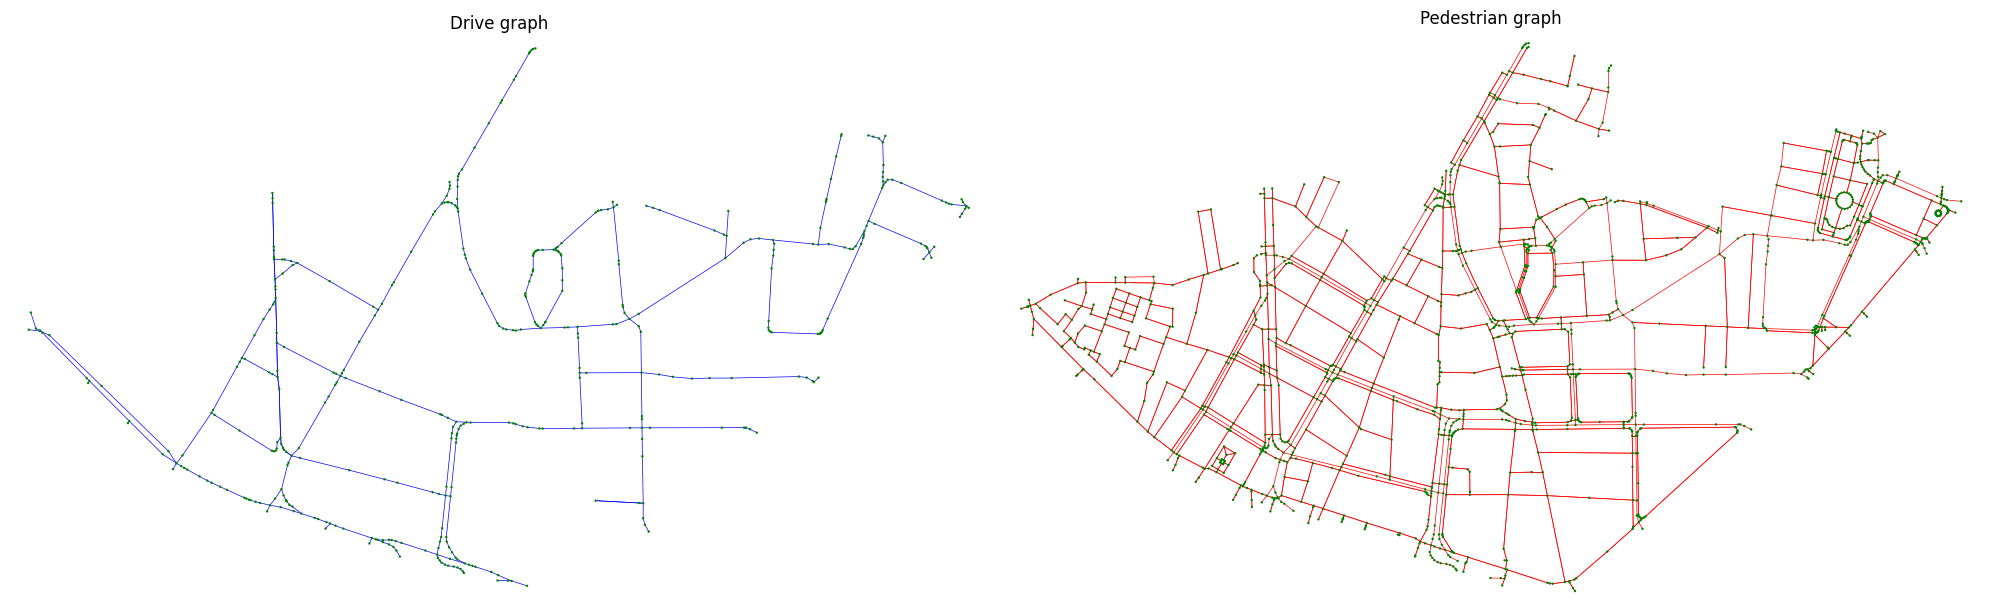

In [4]:
barrio, G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos= get_graph('SANT FRANCESC')
graph_map(G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos)

## Supergraph building

In [5]:
# --- 1. Crear supergrafo vacío y añadir nodos ---
G_super = nx.MultiDiGraph()
G_super.add_nodes_from(G_drive.nodes(data=True))
G_super.add_nodes_from(G_walk.nodes(data=True))

# --- 2. Función para añadir o fusionar aristas con múltiples modos ---
def add_or_merge_edge(G, u, v, key, data, mode):
    data = data.copy()
    modos = data.get('mode', [])
    if not isinstance(modos, list):
        modos = [modos]
    if mode not in modos:
        modos.append(mode)
    data['mode'] = modos

    # Fusionar si existe arista con misma geometría
    if G.has_edge(u, v):
        for k_exist, existing in G[u][v].items():
            if existing.get('geometry') == data.get('geometry'):
                exist_mod = existing.get('mode', [])
                if not isinstance(exist_mod, list):
                    exist_mod = [exist_mod]
                for m in modos:
                    if m not in exist_mod:
                        exist_mod.append(m)
                existing['mode'] = exist_mod
                return
    G.add_edge(u, v, key=key, **data)

# Añadir aristas de conducción
for u, v, k, data in G_drive.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'drive')

# Añadir aristas de caminata (bidireccional)
for u, v, k, data in G_walk.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'walk')
    if not G_walk.has_edge(v, u):
        add_or_merge_edge(G_super, v, u, k, data, 'walk')

# --- Auxiliar: función haversine para distancia geodésica en metros ---
def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    # convertir grados a radianes
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    R = 6371000  # Radio de la Tierra en metros
    return R * c

# --- 3. Función para añadir nodos especiales usando lat/lon ---
def add_special_node(G, geom, tipo, idx):
    nodo_id = f"{tipo}_{idx}"
    lon, lat = geom.centroid.x, geom.centroid.y
    G.add_node(nodo_id, x=lon, y=lat, tipo=tipo)

    conexiones = []
    if tipo == 'carga':
        # Nodo más cercano en red de vehículos
        nd = ox.distance.nearest_nodes(G_drive, lon, lat)
        lon2, lat2 = G_drive.nodes[nd]['x'], G_drive.nodes[nd]['y']
        dist_drive = haversine((lon, lat), (lon2, lat2))
        conexiones.append((nd, 'drive', dist_drive))
        # Nodo más cercano en red peatonal
        nw = ox.distance.nearest_nodes(G_walk, lon, lat)
        lon3, lat3 = G_walk.nodes[nw]['x'], G_walk.nodes[nw]['y']
        dist_walk = haversine((lon, lat), (lon3, lat3))
        conexiones.append((nw, 'walk', dist_walk))
    else:
        # Comercio o almacén: solo red peatonal
        nw = ox.distance.nearest_nodes(G_walk, lon, lat)
        lon3, lat3 = G_walk.nodes[nw]['x'], G_walk.nodes[nw]['y']
        dist_walk = haversine((lon, lat), (lon3, lat3))
        conexiones.append((nw, 'walk', dist_walk))

    # Añadir aristas de conexión bidireccional
    for vecino, modo, dist in conexiones:
        G.add_edge(nodo_id, vecino, mode=['connection', modo], length=dist)
        G.add_edge(vecino, nodo_id, mode=['connection', modo], length=dist)

    return nodo_id

# --- 4. Añadir nodos especiales al supergrafo ---

nodos_carga    = [add_special_node(G_super, row.geometry, 'carga',   i)
                   for i, row in shp_loading_points.iterrows()]
nodos_comercios = [add_special_node(G_super, row.geometry, 'comercio', i)
                   for i, row in shp_bajos[shp_bajos['Comercio']].iterrows()]
nodos_almacenes  = [add_special_node(G_super, row.geometry, 'almacen',  i)
                   for i, row in shp_bajos[shp_bajos['Almacen']].iterrows()]

print(f"✅ Supergraph created: {len(G_super.nodes)} nodes, {len(G_super.edges)} edges.")


✅ Supergraph created: 1731 nodes, 4050 edges.


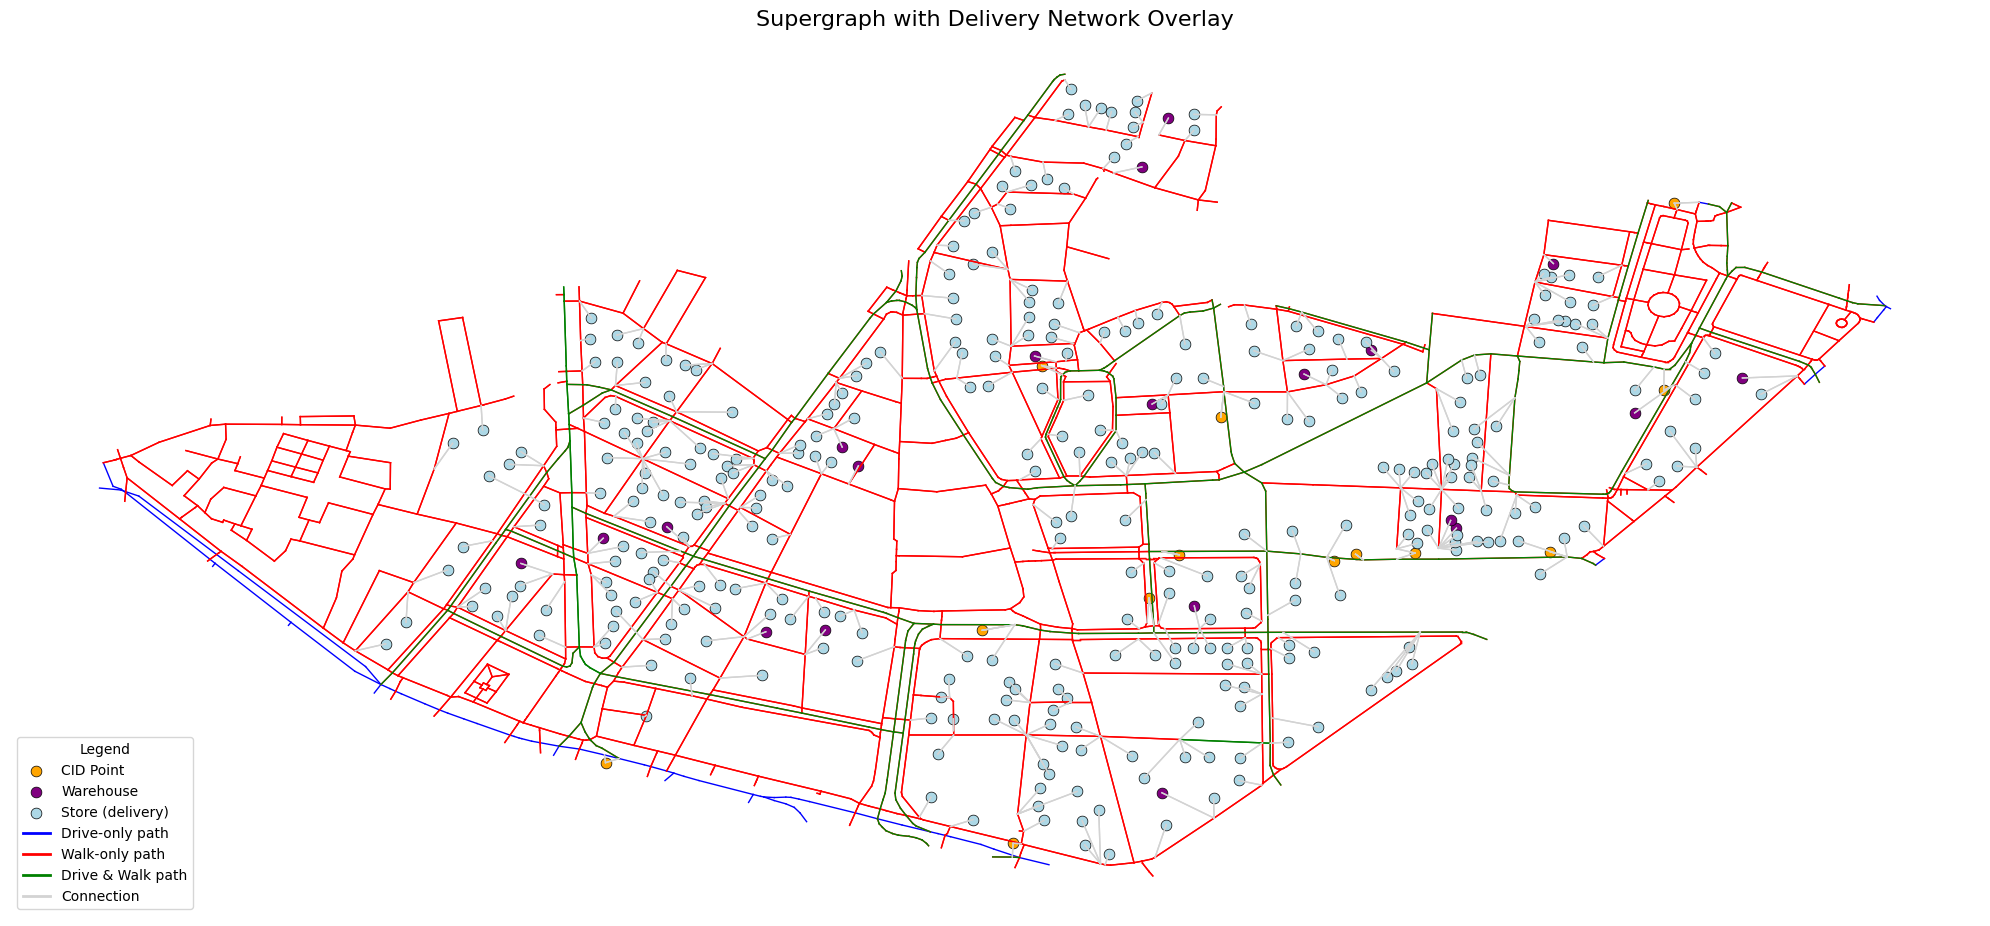

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
# Mantener proporción real en metros
ax.set_aspect('equal', 'box')

# Colores por modo de arista
edge_colors = {
    'drive': 'blue',
    'walk': 'red',
    'drive+walk': 'green',
    'connection': 'lightgray'
}

# Agrupar aristas por modo\
edges_by_mode = {mode: [] for mode in edge_colors}
for u, v, data in G_super.edges(data=True):
    modos = data.get('mode', [])
    # Determinar clave de modo, priorizando conexiones
    if isinstance(modos, list):
        if 'connection' in modos:
            mode_key = 'connection'
        elif 'drive' in modos and 'walk' in modos:
            mode_key = 'drive+walk'
        elif 'drive' in modos:
            mode_key = 'drive'
        elif 'walk' in modos:
            mode_key = 'walk'
        else:
            mode_key = 'connection'
    else:
        mode_key = modos if modos in edge_colors else 'connection'

    # Coordenadas de los nodos
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    edges_by_mode[mode_key].append(((x0, x1), (y0, y1)))

# Dibujar todas las aristas
for mode_key, segments in edges_by_mode.items():
    for xs, ys in segments:
        ax.plot(xs, ys, color=edge_colors[mode_key], linewidth=1)

# Definición de categorías de nodos
categorias = {
    'cid':               {'coords': [], 'color': 'orange',     'label': 'CID Point'},
    'almacen_m3':        {'coords': [], 'color': 'purple',     'label': 'Warehouse'},
    'comercio_entrega':  {'coords': [], 'color': 'lightblue', 'label': 'Store (delivery)'},
    'almacen_y_comercio':{'coords': [], 'color': 'black',      'label': 'Warehouse & Shop'}
}

# Recolectar coordenadas de nodos especiales
for nodo, data in G_super.nodes(data=True):
    tipo = data.get('tipo')
    coord = (data['x'], data['y'])
    if tipo == 'carga':
        categorias['cid']['coords'].append(coord)
    elif tipo == 'almacen' and 'comercio' in nodo:
        categorias['almacen_y_comercio']['coords'].append(coord)
    elif tipo == 'almacen':
        categorias['almacen_m3']['coords'].append(coord)
    elif tipo == 'comercio':
        categorias['comercio_entrega']['coords'].append(coord)

# Dibujar nodos
for cat in categorias.values():
    if cat['coords']:
        xs, ys = zip(*cat['coords'])
        ax.scatter(xs, ys, color=cat['color'], s=60, edgecolor='k', linewidth=0.5, label=cat['label'])

# Crear leyenda de aristas
from matplotlib.lines import Line2D
edge_legend = [
    Line2D([0], [0], color=edge_colors[m], lw=2, label=lab)
    for m, lab in zip(
        ['drive', 'walk', 'drive+walk', 'connection'],
        ['Drive-only path', 'Walk-only path', 'Drive & Walk path', 'Connection']
    )
]

# Ajustar título y ejes
ax.set_title("Supergraph with Delivery Network Overlay", fontsize=16)
ax.axis('off')

# Combinar leyendas y eliminar duplicados
handles_nodes, labels_nodes = ax.get_legend_handles_labels()
handles = handles_nodes + edge_legend
labels = labels_nodes + [h.get_label() for h in edge_legend]
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower left', title='Legend', fontsize=10)

plt.tight_layout()
plt.show()


## M2 Pipeline

### 0 Configuration

In [7]:
N_PAQUETES = 100               # Número total de paquetes a repartir
PAQUETES_MIN = 1               # Mínimo de paquetes por comercio
PAQUETES_MAX = 5               # Máximo de paquetes por comercio
CAPACIDAD_MAXIMA_WALK = 8      # Capacidad máxima que puede cargar el repartidor
CAPACIDAD_MAXIMA_ONA = 20      # Capacidad máxima que puede cargar el robot
VELOCIDAD_VEHICULO = 35        # Velocidad de la furgoneta en km/h si no hay en la arista max_speed
VELOCIDAD_PEATON = 5           # Velocidad del repartidor a pie en km/h
VELOCIDAD_CONEXION = 10        # Velocidad de las aristas de conexión en modo drive km/h


### 1 Deliveries sample

In [8]:
# ==============================
# Seleccionar comercios y asignar paquetes
# ==============================

paquetes_asignados = 0
bajos_seleccionados = []
paquetes_por_nodo = []

while paquetes_asignados < N_PAQUETES:
    max_pos = min(PAQUETES_MAX, N_PAQUETES - paquetes_asignados)
    if max_pos < PAQUETES_MIN: break

    nodo = random.choice(nodos_comercios)
    asignado_nodo = sum(p for nn, p in zip(bajos_seleccionados, paquetes_por_nodo) if nn == nodo)
    disponible_nodo = CAPACIDAD_MAXIMA_ONA - asignado_nodo
    if disponible_nodo < PAQUETES_MIN: continue

    paquetes = random.randint(PAQUETES_MIN, min(max_pos, disponible_nodo))
    bajos_seleccionados.append(nodo)
    paquetes_por_nodo.append(paquetes)
    paquetes_asignados += paquetes

# Agrupar y sumar por nodo 
bajos_sample = gpd.GeoDataFrame(
    pd.DataFrame([{
        'nodo': n,
        'paquetes': sum(p for nn, p in zip(bajos_seleccionados, paquetes_por_nodo) if nn == n),
        **G_super.nodes[n]
    } for n in set(bajos_seleccionados)]),
    geometry=[Point(G_super.nodes[n]['x'], G_super.nodes[n]['y']) for n in set(bajos_seleccionados)],
    crs="EPSG:4326"
)

display(bajos_sample)


nodo  paquetes         x          y      tipo  \
0   comercio_20361         3 -0.374808  39.468965  comercio   
1   comercio_17080         2 -0.379089  39.469817  comercio   
2   comercio_19674         5 -0.376352  39.471198  comercio   
3   comercio_19688         3 -0.375649  39.471718  comercio   
4   comercio_20371         2 -0.374642  39.468898  comercio   
5   comercio_21140         3 -0.373635  39.471705  comercio   
6   comercio_19660         2 -0.375513  39.470121  comercio   
7   comercio_21891         5 -0.371245  39.470042  comercio   
8   comercio_19665         2 -0.375633  39.470067  comercio   
9   comercio_17699         4 -0.378000  39.470423  comercio   
10  comercio_23329         4 -0.370243  39.471313  comercio   
11  comercio_17696         1 -0.378166  39.470038  comercio   
12  comercio_17106         2 -0.379152  39.470249  comercio   
13  comercio_21886         3 -0.372055  39.470175  comercio   
14  comercio_21909         1 -0.372690  39.470127  comercio   
15  comercio_19711         2 -0.375842  39.472877  comercio   
16  comercio_18765         3 -0.376418  39.471478  comercio   
17  comercio_18770         1 -0.376529  39.472137  comercio   
18  comercio_15847         2 -0.380356  39.470456  comercio   
19  comercio_19635         3 -0.375695  39.467977  comercio   
20  comercio_17117         5 -0.378630  39.471340  comercio   
21  comercio_19649         2 -0.376529  39.468764  comercio   
22  comercio_18768         1 -0.376471  39.471760  comercio   
23  comercio_21126         2 -0.372784  39.470509  comercio   
24  comercio_17671         2 -0.378086  39.468795  comercio   
25  comercio_19706         3 -0.375974  39.472992  comercio   
26  comercio_18749         3 -0.377320  39.470936  comercio   
27  comercio_17107         1 -0.379079  39.470351  comercio   
28  comercio_23321         2 -0.369769  39.471135  comercio   
29  comercio_20342         4 -0.374452  39.468407  comercio   
30  comercio_20405         5 -0.375234  39.471652  comercio   
31  comercio_19687         1 -0.375615  39.471893  comercio   
32  comercio_19668         1 -0.375545  39.471476  comercio   
33  comercio_21915         2 -0.372109  39.471297  comercio   
34  comercio_17116         4 -0.378724  39.471376  comercio   
35  comercio_19693         3 -0.375680  39.471611  comercio   
36  comercio_21907         1 -0.372703  39.469974  comercio   
37  comercio_19610         1 -0.376620  39.468140  comercio   
38  comercio_21136         3 -0.373711  39.470930  comercio   
39  comercio_19629         1 -0.375195  39.467312  comercio   

                     geometry  
0   POINT (-0.37481 39.46896)  
1   POINT (-0.37909 39.46982)  
2    POINT (-0.37635 39.4712)  
3   POINT (-0.37565 39.47172)  
4    POINT (-0.37464 39.4689)  
5   POINT (-0.37363 39.47171)  
6   POINT (-0.37551 39.47012)  
7   POINT (-0.37125 39.47004)  
8   POINT (-0.37563 39.47007)  
9     POINT (-0.378 39.47042)  
10  POINT (-0.37024 39.47131)  
11  POINT (-0.37817 39.47004)  
12  POINT (-0.37915 39.47025)  
13  POINT (-0.37206 39.47017)  
14  POINT (-0.37269 39.47013)  
15  POINT (-0.37584 39.47288)  
16  POINT (-0.37642 39.47148)  
17  POINT (-0.37653 39.47214)  
18  POINT (-0.38036 39.47046)  
19   POINT (-0.3757 39.46798)  
20  POINT (-0.37863 39.47134)  
21  POINT (-0.37653 39.46876)  
22  POINT (-0.37647 39.47176)  
23  POINT (-0.37278 39.47051)  
24   POINT (-0.37809 39.4688)  
25  POINT (-0.37597 39.47299)  
26  POINT (-0.37732 39.47094)  
27  POINT (-0.37908 39.47035)  
28  POINT (-0.36977 39.47113)  
29  POINT (-0.37445 39.46841)  
30  POINT (-0.37523 39.47165)  
31  POINT (-0.37562 39.47189)  
32  POINT (-0.37554 39.47148)  
33   POINT (-0.37211 39.4713)  
34  POINT (-0.37872 39.47138)  
35  POINT (-0.37568 39.47161)  
36   POINT (-0.3727 39.46997)  
37  POINT (-0.37662 39.46814)  
38  POINT (-0.37371 39.47093)  
39   POINT (-0.3752 39.46731)

### 2 Hub selection

In [9]:


# 1. Filtrar sólo los nodos que sean almacén
almacenes = [n for n, d in G_super.nodes(data=True) if d.get('tipo') == 'almacen']
if not almacenes:
    raise ValueError("No hay nodos con tipo 'almacen' en G_super.")



# 2. Calcular el centroide del grafo (media de todas las coordenadas de nodos)
xs = [data['x'] for _, data in G_super.nodes(data=True)]
ys = [data['y'] for _, data in G_super.nodes(data=True)]
centroide = Point(np.mean(xs), np.mean(ys))

# 3. Medir la distancia euclídea de cada almacén al centroide
distancias = []
for n in almacenes:
    pt = Point(G_super.nodes[n]['x'], G_super.nodes[n]['y'])
    dist = centroide.distance(pt)
    distancias.append((n, dist))

# 4. Tomar el 25% de almacenes más centricos
CANDIDATOS = round(len(almacenes)/4)  # Número de almacenes a seleccionar
candidatos = sorted(distancias, key=lambda x: x[1])[:CANDIDATOS]
almacenes_cercanos = [n for n, _ in candidatos]

# 5. Elegir uno al azar
hub = random.choice(almacenes_cercanos)

# 6. Calcular area 
idx = int(hub[-5:])
area_m2 = gpd.GeoDataFrame(geometry=[shp_bajos.loc[idx, 'geometry']], crs=4326).to_crs(25830).geometry.area[0]

print(f"✅ Selected hub: {hub} ({area_m2:.2f} m²)")



✅ Selected hub: almacen_18736 (537.70 m²)


### 3 Clusters

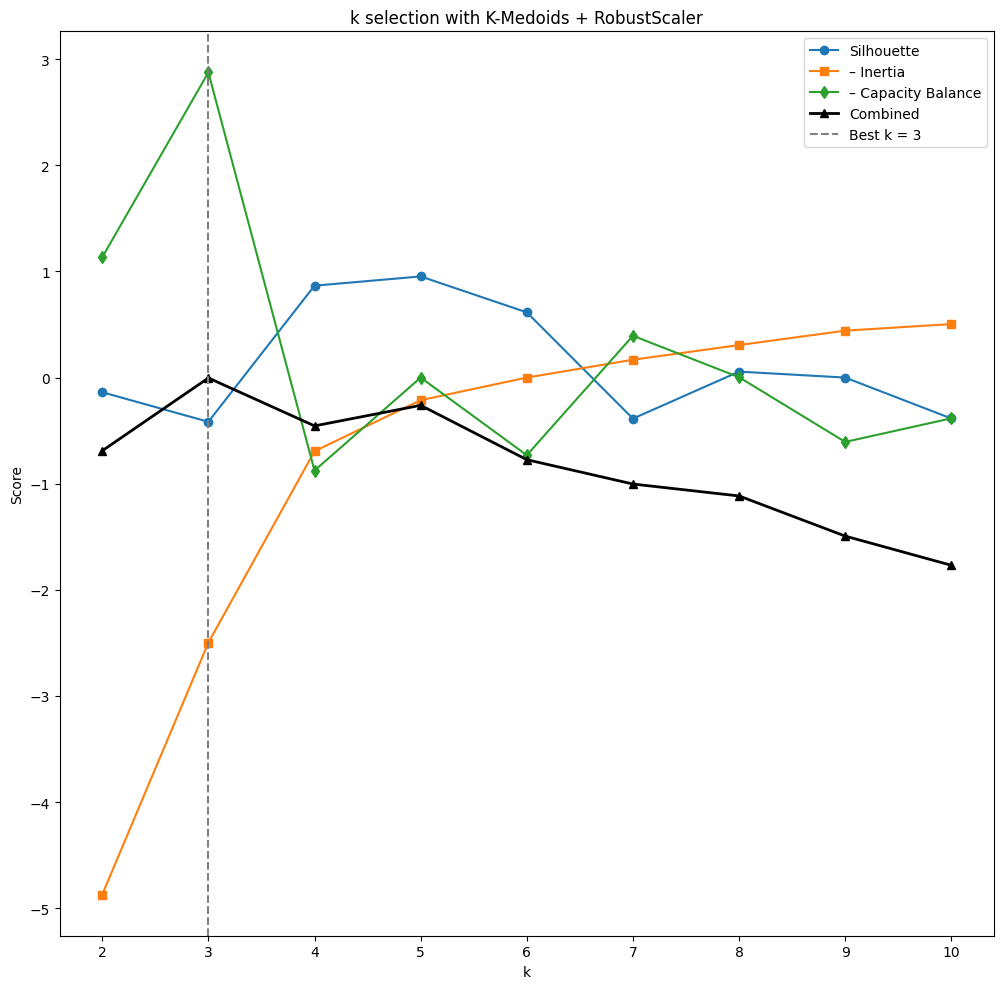

✅ Deliveries assigned to 3 robots (K-Medoids + hub-balanced).


In [10]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1) Parámetros
# ------------------------------
K_MIN   = 2
K_MAX   = 10
ALPHA   = 0.4  # peso Silhouette
BETA    = 0.2  # peso Inertia
GAMMA   = 0.3  # peso Balance de capacidad
OMEGA   = 0.2  # costes fijos de un nuevo robot

# -------------------------------------------------------------------
# Function: estimate_best_k_with_kmedoids + capacity balance w/ hub
# -------------------------------------------------------------------
def estimate_best_k_with_kmedoids(feats, demands, coords, hub_coord, cap_max,
                                   k_min=2, k_max=10,
                                   alpha=ALPHA, beta=BETA, gamma=GAMMA, omega=OMEGA):
    ks, sils, ines, balances = [], [], [], []
    hub_x, hub_y = hub_coord

    for k in range(k_min, min(k_max+1, len(feats))):
        # 1) Train K-Medoids
        kmed = KMedoids(n_clusters=k,
                        init='k-medoids++', method='pam', metric='euclidean', random_state=33)
        labels = kmed.fit_predict(feats)

        # 2) Silhouette
        sil = silhouette_score(feats, labels) if k > 1 else 0

        # 3) Inertia manual using medoid positions
        medoids = feats[kmed.medoid_indices_]
        inertia = sum(np.sum((feats[labels==j] - medoids[j])**2)
                      for j in range(k))

        # 4) Capacity balance error weighted by centroid-to-hub distance
        loads = np.array([demands[labels==j].sum() for j in range(k)])
        mults = np.ceil(loads / cap_max) * cap_max
        errors = np.abs(loads - mults)

        # compute centroids of each cluster in geographic space
        balances_k = []
        for j in range(k):
            pts = coords[labels==j]
            rmse = np.sqrt(np.mean((pts[:, 0] - hub_x)**2 + (pts[:, 1] - hub_y)**2))
            balances_k.append(errors[j] * rmse)
        bal = np.mean(balances_k)

        ks.append(k)
        sils.append(sil)
        ines.append(inertia)
        balances.append(bal)

    # 5) Robust scaling
    scaler = RobustScaler()
    sil_r = scaler.fit_transform(np.array(sils).reshape(-1,1)).ravel()
    ine_r = -scaler.fit_transform(np.array(ines).reshape(-1,1)).ravel()
    bal_r = -scaler.fit_transform(np.array(balances).reshape(-1,1)).ravel()

    # 6) Combined score with penalty on cluster count
    combined = alpha * sil_r + beta * ine_r + gamma * bal_r - omega * np.arange(len(ks))
    best_idx = np.argmax(combined)
    best_k = ks[best_idx]

    # 7) Diagnostic plot
    fig, ax = plt.subplots(figsize=(12,10))
    ax.set_aspect('equal', 'box')
    ax.plot(ks, sil_r, marker='o', label='Silhouette')
    ax.plot(ks, ine_r, marker='s', label='– Inertia')
    ax.plot(ks, bal_r, marker='d', label='– Capacity Balance')
    ax.plot(ks, combined, marker='^', lw=2, color='black', label='Combined')
    ax.axvline(best_k, ls='--', color='gray', label=f'Best k = {best_k}')
    ax.set(xlabel='k', ylabel='Score', title='k selection with K-Medoids + RobustScaler')
    ax.legend(); plt.tight_layout(); plt.show()

    return best_k

# -------------------------------------------------------------------
# Usage example
# -------------------------------------------------------------------
# coords array of shape (n_samples, 2): puntos de entrega
coords = np.vstack([bajos_sample.geometry.x.values,
                    bajos_sample.geometry.y.values]).T
hub_coord = (G_super.nodes[hub]['x'], G_super.nodes[hub]['y'])
demands = bajos_sample['paquetes'].to_numpy()

best_k = estimate_best_k_with_kmedoids(
    feats=coords,
    demands=demands,
    coords=coords,
    hub_coord=hub_coord,
    cap_max=CAPACIDAD_MAXIMA_ONA,
    k_min=2, k_max=10,
    alpha=ALPHA, beta=BETA, gamma=GAMMA, omega=OMEGA
)

# Final K-Medoids clustering
kmed = KMedoids(n_clusters=best_k, init='k-medoids++', method='pam', metric='euclidean', random_state=33)
labels = kmed.fit_predict(coords)
bajos_sample['grupo_repartidor'] = labels + 1
print(f"✅ Deliveries assigned to {best_k} robots (K-Medoids + hub-balanced).")


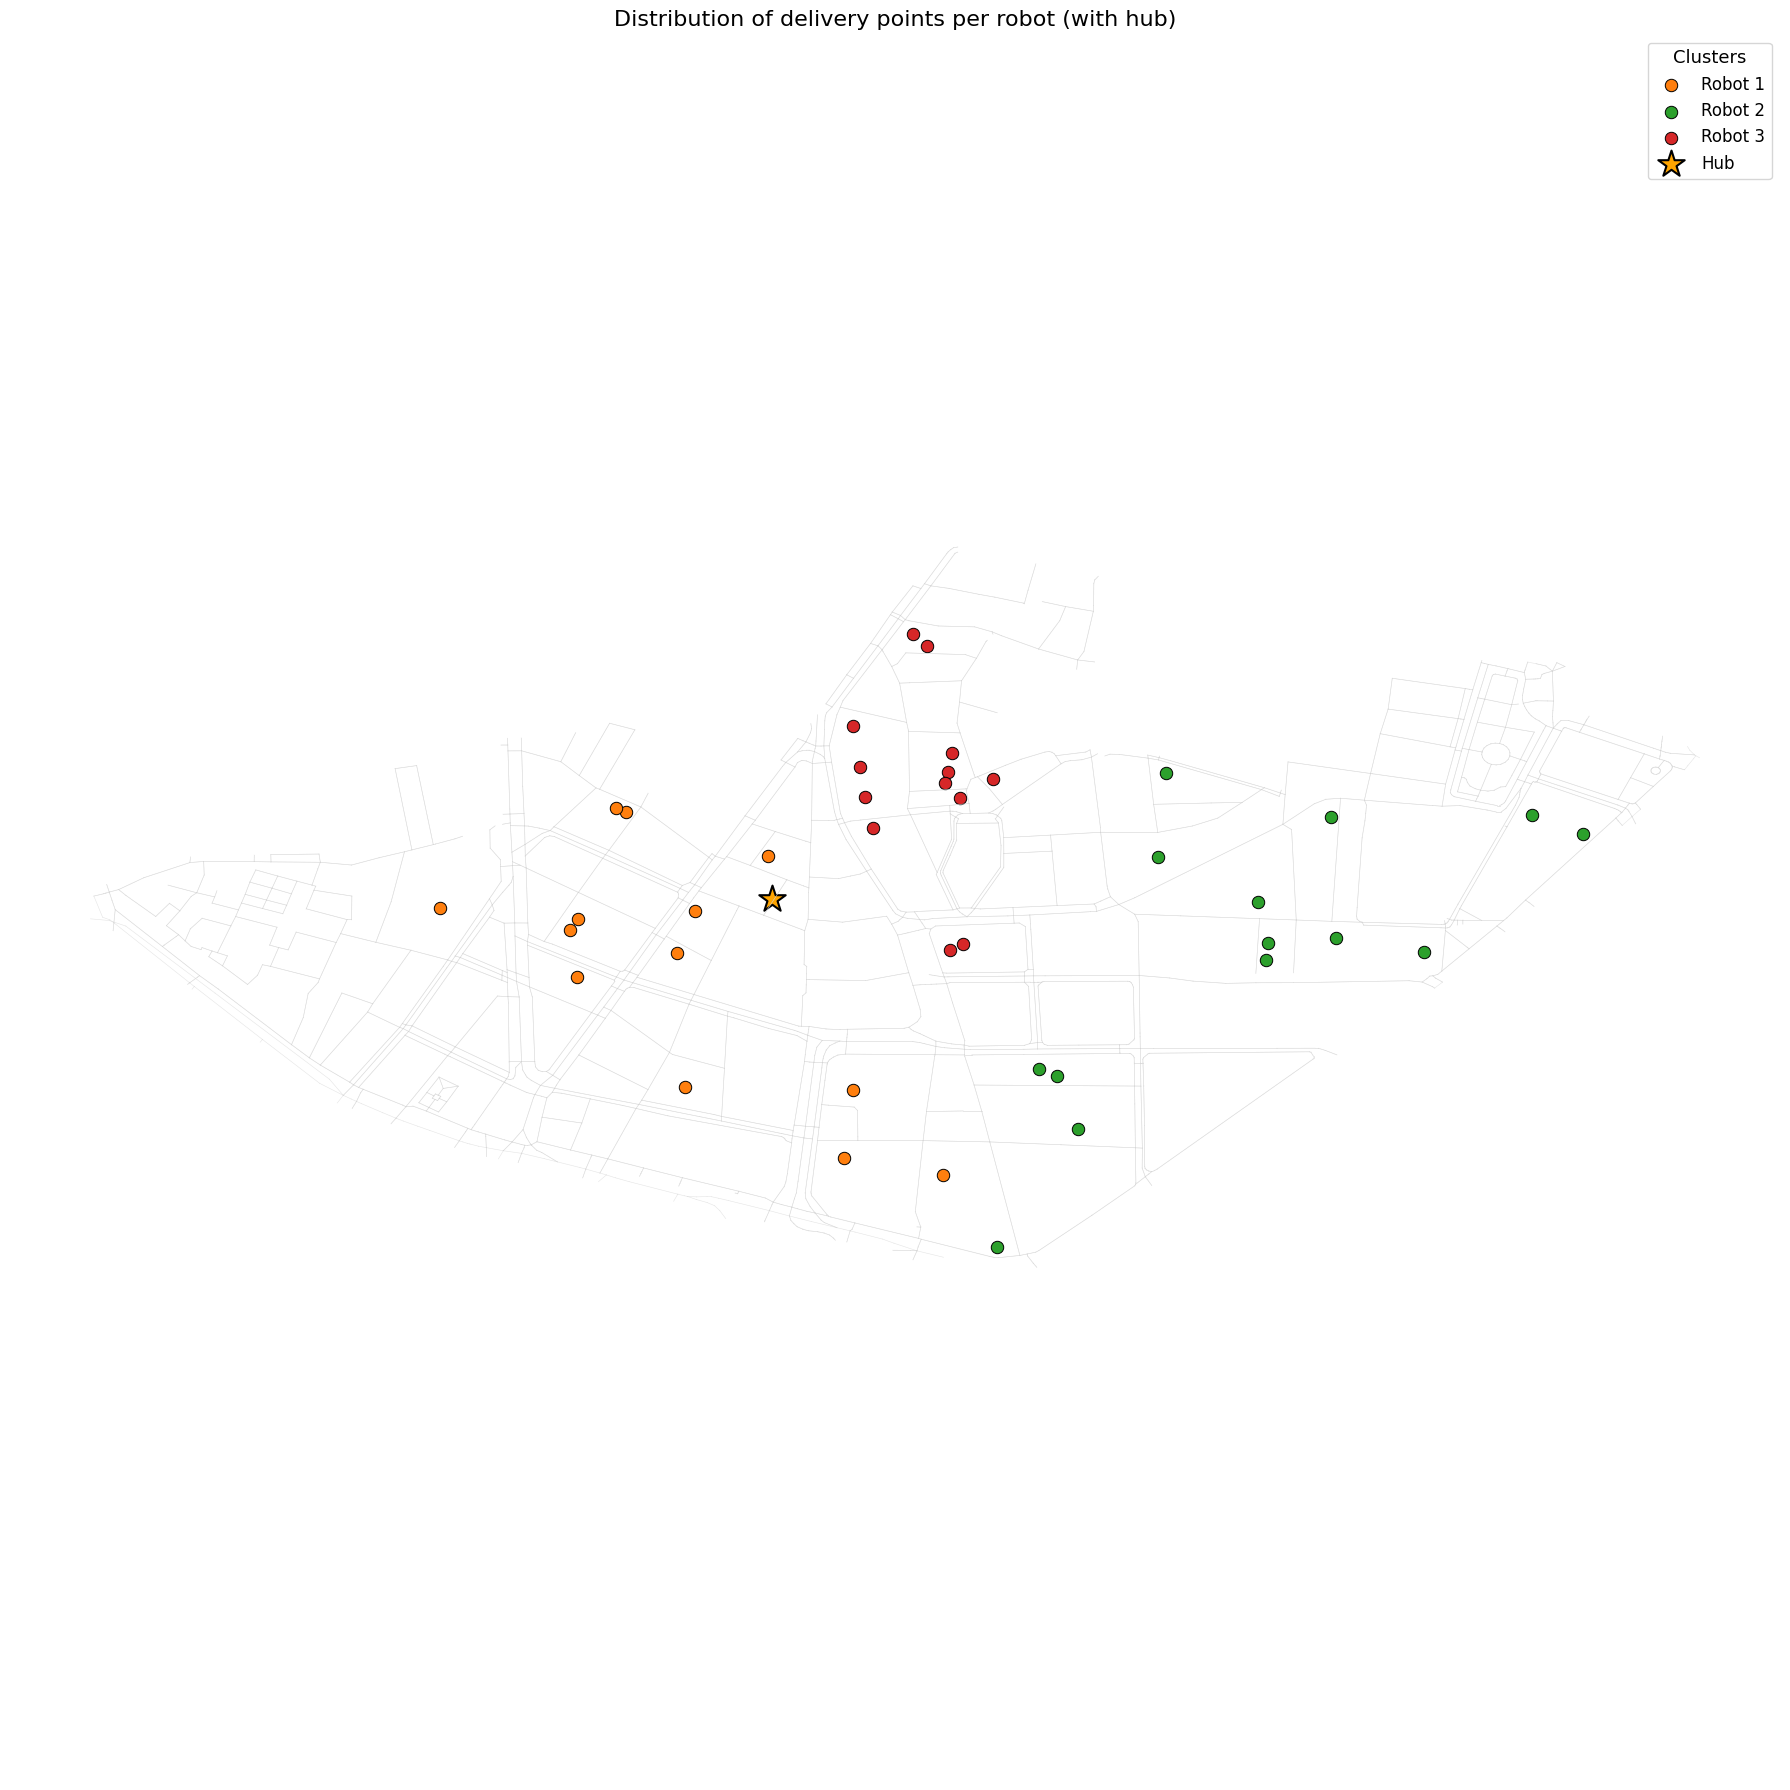

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.path import Path

# ==============================
# Visualize G_super + delivery points by cluster + fancy hub
# ==============================

fig, ax = plt.subplots(figsize=(18, 18))
ax.set_aspect('equal', 'box')

# 1. Draw the edges of the supergraph (all streets)
for u, v, data in G_super.edges(data=True):
    if isinstance(u, str) or isinstance(v, str):
        continue
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    ax.plot([x0, x1], [y0, y1], color='lightgray', linewidth=0.4, alpha=0.6)

# 2. Plot delivery points grouped by cluster
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
for group in sorted(bajos_sample['grupo_repartidor'].unique()):
    grp_pts = bajos_sample[bajos_sample['grupo_repartidor'] == group]
    xs, ys = grp_pts.geometry.x, grp_pts.geometry.y
    ax.scatter(xs, ys,
               s=80,
               color=colors[group % len(colors)],
               edgecolor='black',
               linewidth=0.7,
               label=f'Robot {group}')

# 4. Plot the hub 
hub_x = G_super.nodes[hub]['x']
hub_y = G_super.nodes[hub]['y']
ax.scatter(hub_x, hub_y,
           marker="*",
           s=400,                       # size of the marker
           facecolor='orange',          # fill color
           edgecolor='black',           # border color
           linewidth=1.5,
           label='Hub')

# 5. General plot style
ax.set_title("Distribution of delivery points per robot (with hub)", fontsize=16)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
ax.axis('off')
ax.legend(title="Clusters", fontsize=12, title_fontsize=13, loc='upper right')

plt.tight_layout()
plt.show()


### 3 Routing

In [12]:
# ==============================
# 1. FUNCIONES DE TIEMPO
# ==============================
def tiempo_por_distancia(distancia_metros, velocidad_kmh):
    """Convierte distancia en metros y velocidad en km/h a tiempo en minutos."""
    return distancia_metros / (velocidad_kmh * 1000 / 60)

def calcular_tiempos_en_aristas(G, VELOCIDAD_PEATON=5, VELOCIDAD_VEHICULO=35, VELOCIDAD_CONNECTION=10):
    """
    Añade a cada arista del grafo G los tiempos de caminata (tiempo_walk)
    y de conducción (tiempo_drive) según su modo ('walk','drive','connection') de distribuciones normales.
    """

    v_peaton = np.random.normal(VELOCIDAD_PEATON, 0.2 * VELOCIDAD_PEATON, size=30)
    v_connection = np.random.normal(VELOCIDAD_CONNECTION, 0.2 * VELOCIDAD_CONNECTION, size=30)
    v_vehiculo = np.random.normal(VELOCIDAD_VEHICULO, 0.2 * VELOCIDAD_VEHICULO, size=30)

    for u, v, k, data in G.edges(keys=True, data=True):
        d = data.get('length', 100)
        modos = data.get('mode', ['walk'])

        if 'connection' in modos:
            data['tiempo_walk'] = tiempo_por_distancia(d, np.random.choice(v_peaton))
            data['tiempo_drive'] = tiempo_por_distancia(d, np.random.choice(v_connection))
            continue

        if 'walk' in modos:
            data['tiempo_walk'] = tiempo_por_distancia(d, np.random.choice(v_peaton))

        if 'drive' in modos:
            v_max = data.get('maxspeed', np.random.choice(v_vehiculo))
            if isinstance(v_max, str):
                v_max = int(''.join(filter(str.isdigit, v_max)) or 30)
            v_kmh = max(v_max * 0.5, np.random.normal(v_max * 0.8, v_max * 0.1))
            data['tiempo_drive'] = tiempo_por_distancia(d, v_kmh)

        data.setdefault('tiempo_walk', float('inf'))
        data.setdefault('tiempo_drive', float('inf'))

def calcular_tiempo_drive(origen, destino):
    """Ruta más rápida en vehículo entre origen y destino (minutos)."""
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_drive')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed    = G_super.get_edge_data(u, v)
        t_min = min(e['tiempo_drive'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

def calcular_tiempo_walk(origen, destino):
    """Ruta más rápida a pie entre origen y destino (minutos)."""
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_walk')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed    = G_super.get_edge_data(u, v)
        t_min = min(e['tiempo_walk'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

# ==============================
# 2. FUNCIONES AUXILIARES
# ==============================
def obtener_centroide_grupo(df_grupo):
    """Centroide geográfico de un DataFrame de geometrías."""
    return df_grupo.geometry.union_all().centroid

def distancia_euclidea(x1, y1, x2, y2):
    """Distancia euclídea en 2D."""
    return np.hypot(x1 - x2, y1 - y2)

def nodo_cid_mas_cercano(geom, nodos_cid):
    """Nodo CiD más cercano por distancia euclídea."""
    coords = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in nodos_cid]
    tree   = cKDTree(coords)
    _, idx = tree.query((geom['y'], geom['x']))
    return nodos_cid[idx]

def calcular_matriz_distancias(pendientes, nodo_cid):
    """
    Matriz de distancias a pie entre todos los nodos pendientes + nodo CiD.
    """
    distancias = {}
    puntos     = pendientes['nodo'].tolist() + [nodo_cid]
    for n1 in puntos:
        distancias[n1] = {}
        for n2 in puntos:
            if n1 == n2:
                continue
            t, _ = calcular_tiempo_walk(n1, n2)
            distancias[n1][n2] = t
    return distancias

# ==============================
# 3. INICIALIZACIÓN
# ==============================

calcular_tiempos_en_aristas(G_super)

print("======= MODEL M2 TIME LOG =======\n")

grupos_pendientes = set(bajos_sample['grupo_repartidor'].unique())
entry_info = None
paquetes_camion = N_PAQUETES

# parámetro inicial para node-boundary
thresh = 0.00005

# contadores globales
tiempo_total_total = tiempo_drive_total = tiempo_walk_total = 0.0

# ==============================
# 4. ENTRADA HASTA EL CLUSTER (FASE 1)
# ==============================

inicio_furgoneta = None
ruta_drive = None


while entry_info is None:
    boundary_nodes = [
            n for n,d in G_drive.nodes(data=True)
            if shp_zone.boundary.distance(Point(d['x'], d['y'])) < thresh
        ]
    if len(boundary_nodes) < 8:
        if thresh < 0.1:
                thresh = min(thresh * 3, 0.1)
                continue
        else:
            raise RuntimeError("No se encontró entrada válida para los clústeres restantes.")
            
    random.shuffle(boundary_nodes)

    # intentar encontrar entrada válida; si falla, aumentar thresh hasta 0.05
    cid_cand = nodo_cid_mas_cercano(G_super.nodes[hub], nodos_carga)
    for bnd in boundary_nodes:
        t_drive, camino = calcular_tiempo_drive(bnd, cid_cand)
        if camino and np.isfinite(t_drive):
            entry_info = (bnd, cid_cand, camino[1:], t_drive)
            break

    if entry_info is None:
        # si no encontramos y aún podemos aumentar thresh
        if thresh < 0.1:
            thresh = min(thresh * 3, 0.1)
            continue
        else:
            raise RuntimeError("No se encontró entrada válida para los clústeres restantes.")

    # desempaquetar entrada válida
    entry, nodo_cid, ruta_drive, tiempo_drive = entry_info
    inicio_furgoneta = entry
    ruta_drive = camino
    tiempo_drive_total += tiempo_drive

print("===🚛 PHASE 1: Driving Route into the CID 🚛===")
print(f"• Selected entry node (random): {entry}")
print(f"• Time to enter CID: {tiempo_drive_total:.1f} min\n")

# ==============================
# 5. DESCARGA DEL CAMIÓN (CID AL HUB) (FASE 2)
# ==============================

carga_actual = 0
rutas_descarga   = []
tiempos_descarga = []

print("===🏢 PHASE 2: Unloading Truck from CID to HUB 🏢===")


while paquetes_camion > 0:
    carga_actual = min(paquetes_camion, CAPACIDAD_MAXIMA_WALK)
    paquetes_camion -= carga_actual
    # calcular tiempo de ir del cid al hub
    t_ida, camino_ida = calcular_tiempo_walk(nodo_cid, hub)
    tiempo_walk_total += t_ida
    print(f"• {carga_actual} packages on foot from CID to HUB ({tiempo_walk_total:.1f} min)")
    rutas_descarga.append(camino_ida[1:])
    tiempos_descarga.append(t_ida)

    if paquetes_camion != 0: # hay que volver al cid si aun quedan paquetes en el camion
        t_back, camino_back = calcular_tiempo_walk(hub, nodo_cid)
        tiempo_walk_total += t_back
        print(f"  ↳ Returning on foot from HUB to CID ({tiempo_walk_total:.1f} min)")
        rutas_descarga.append(camino_back[1:])
        tiempos_descarga.append(t_back)
print(f"• Truck fully unloaded. Total walking time: {tiempo_walk_total:.1f} min\n")
# ==============================
# 6. REPARTO DE PAQUETES POR CLUSTER (FASE 3)
# ==============================

rutas_y_tiempos   = []

print("===🤖 PHASE 3: ONA Deliveries from HUB 🤖===")

# preparativos para entregas a pie
while grupos_pendientes:
    grupo_sel = grupos_pendientes.pop()
    sub_bajos  = bajos_sample[bajos_sample['grupo_repartidor']==grupo_sel]
    pendientes = sub_bajos.copy()
    nodo_actual = hub
    carga_actual = 0
    rutas_walk_cluster   = []
    tiempos_walk_cluster = []
    tiempo_walk_cluster = 0.0

    print(f"\n  📍 ONA Nº{grupo_sel} route")
    print("    No.  |       Node        | Packages | Arrival (min)")
    print("    -----+-------------------+----------+---------------")

    matriz_dist = calcular_matriz_distancias(pendientes, hub)

    # nearest‐neighbor greedy + recarga
    while not pendientes.empty:
        dist_map = { n: matriz_dist[nodo_actual][n] for n in pendientes['nodo'] }
        nodo_sig = min(dist_map, key=dist_map.get)
        pkgs     = pendientes.loc[pendientes['nodo']==nodo_sig, 'paquetes'].item()

        # recargar si excede capacidad
        if carga_actual + pkgs > CAPACIDAD_MAXIMA_ONA:
            t_back, camino_back = calcular_tiempo_walk(nodo_actual, hub)
            dist_back = sum(
                G_super.get_edge_data(u,v)[0]['length']
                for u,v in zip(camino_back[:-1], camino_back[1:])
            )
            tiempo_walk_cluster += t_back
            rutas_walk_cluster[-1] = rutas_walk_cluster[-1] + camino_back[1:]
            nodo_actual = hub
            carga_actual = 0
            continue

        # entrega
        t_ida, camino_ida = calcular_tiempo_walk(nodo_actual, nodo_sig)
        dist_ida = sum(
            G_super.get_edge_data(u,v)[0]['length']
            for u,v in zip(camino_ida[:-1], camino_ida[1:])
        )
        tiempo_entrega = np.random.normal(loc=1.5, scale=0.5)
        tiempo_walk_cluster += t_ida + tiempo_entrega
        rutas_walk_cluster.append(camino_ida[1:])
        tiempos_walk_cluster.append(tiempo_walk_cluster)

        
        print(f"    {len(rutas_walk_cluster):>3}  | {nodo_sig:<17} | {pkgs:^8} | {tiempo_walk_cluster:>13.2f}")
     

        carga_actual += pkgs
        pendientes = pendientes[pendientes['nodo']!=nodo_sig]
        nodo_actual = nodo_sig


        

    # almacenar resultados
    rutas_y_tiempos.append({
        'grupo_repartidor': grupo_sel,
        'tiempo_walk':      tiempo_walk_cluster,
        'rutas_walk':       rutas_walk_cluster,
        'tiempos_walk':     tiempos_walk_cluster
    })

    tiempo_walk_total  += tiempo_walk_cluster

total_onas = sum(x['tiempo_walk'] for x in rutas_y_tiempos)
print(f"\n🤖 Total ONAs deployment time: {total_onas:.1f} min")


tiempo_total_total = tiempo_drive_total + tiempo_walk_total

# ==============================
# 5. RESULTADOS FINALES
# ==============================
df_rutas_y_tiempos = pd.DataFrame(rutas_y_tiempos)
print("\n===📦 OVERALL RESULTS 📦===")
print(f"⏱️ Total delivery time: {tiempo_total_total:.1f} min")
print(f"🚐 Total driving time:  {tiempo_drive_total:.1f} min")
print(f"🚶‍♂️ Total walking time: {tiempo_walk_total:.1f} min\n")



======= MODEL M2 TIME LOG =======

===🚛 PHASE 1: Driving Route into the CID 🚛===
• Selected entry node (random): 29935867
• Time to enter CID: 1.5 min

===🏢 PHASE 2: Unloading Truck from CID to HUB 🏢===
• 8 packages on foot from CID to HUB (3.4 min)
  ↳ Returning on foot from HUB to CID (6.8 min)
• 8 packages on foot from CID to HUB (10.2 min)
  ↳ Returning on foot from HUB to CID (13.5 min)
• 8 packages on foot from CID to HUB (16.9 min)
  ↳ Returning on foot from HUB to CID (20.3 min)
• 8 packages on foot from CID to HUB (23.7 min)
  ↳ Returning on foot from HUB to CID (27.1 min)
• 8 packages on foot from CID to HUB (30.5 min)
  ↳ Returning on foot from HUB to CID (33.9 min)
• 8 packages on foot from CID to HUB (37.3 min)
  ↳ Returning on foot from HUB to CID (40.6 min)
• 8 packages on foot from CID to HUB (44.0 min)
  ↳ Returning on foot from HUB to CID (47.4 min)
• 8 packages on foot from CID to HUB (50.8 min)
  ↳ Returning on foot from HUB to CID (54.2 min)
• 8 packages on foot fr

### 4 Results mapping

In [13]:
import folium
import math
import numpy as np
from folium import Marker, PolyLine, CircleMarker, GeoJson, LayerControl
from folium.plugins import MarkerCluster
from folium.features import DivIcon
import matplotlib.colors as mcolors
from collections import defaultdict

# 1️⃣ Colores por cluster
cluster_ids = sorted(bajos_sample['grupo_repartidor'].unique())
base_colors = list(mcolors.TABLEAU_COLORS.values())
cluster_colors = {
    cid: base_colors[i % len(base_colors)]
    for i, cid in enumerate(cluster_ids)
}

# 2️⃣ Calcula order_map (número de entrega por comercio)
order_map = {}
for _, row in df_rutas_y_tiempos.iterrows():
    grp   = row['grupo_repartidor']
    rutas = row['rutas_walk']
    order_map[grp] = {
        path[-1]: idx
        for idx, path in enumerate(rutas, start=1)
    }

# 3️⃣ Prepara lista de puntos: comercios, CID y HUB
items = []
for _, r in bajos_sample.iterrows():
    nodo, grp = r['nodo'], r['grupo_repartidor']
    y, x       = G_super.nodes[nodo]['y'], G_super.nodes[nodo]['x']
    items.append((y, x, 'comercio', nodo, grp))
if ruta_drive:
    cid = ruta_drive[-1]
    y, x = G_super.nodes[cid]['y'], G_super.nodes[cid]['x']
    items.append((y, x, 'cid', cid, None))
y_hub, x_hub = G_super.nodes[hub]['y'], G_super.nodes[hub]['x']
items.append((y_hub, x_hub, 'hub', hub, None))

# 4️⃣ Agrupa por ubicación para evitar solapamientos
loc_groups = defaultdict(list)
for it in items:
    loc = (round(it[0],6), round(it[1],6))
    loc_groups[loc].append(it)

# 5️⃣ Crea el mapa con fondo CartoDB Positron
centro = [
    np.mean([d['y'] for _, d in G_super.nodes(data=True)]),
    np.mean([d['x'] for _, d in G_super.nodes(data=True)])
]
m = folium.Map(location=centro, zoom_start=16, tiles="CartoDB Positron")

# 6️⃣ Dibuja tu zona (shapefile)
GeoJson(
    shp_zone,
    style_function=lambda f: {
        "color":"green","weight":4,
        "fillColor":"limegreen","fillOpacity":0.1
    }
).add_to(m)

# 7️⃣ [ELIMINADO] grafo de fondo

# 8️⃣ Añade marcadores: comercios (+número), CID y HUB
R = 7
for (lat0, lon0), group in loc_groups.items():
    if len(group) > 1:
        folium.Circle(
            location=(lat0, lon0), radius=10,
            color="black", weight=1,
            fill=True, fill_color="black", fill_opacity=0.2
        ).add_to(m)
    for idx, (lat, lon, tipo, nodo, grp) in enumerate(group):
        if len(group) == 1:
            lat_j, lon_j = lat, lon
        else:
            angle = 2 * math.pi * idx / len(group)
            dlat  = (10 * math.cos(angle)) / 111000
            dlon  = (10 * math.sin(angle)) / (111000 * math.cos(math.radians(lat0)))
            lat_j, lon_j = lat0 + dlat, lon0 + dlon

        if tipo == 'comercio':
            color = cluster_colors[grp]
            CircleMarker(
                location=(lat_j, lon_j), radius=R,
                color=color, fill=True, fill_opacity=0.8
            ).add_to(m)
            nro = order_map[grp].get(nodo)
            if nro:
                Marker(
                    location=(lat_j, lon_j),
                    icon=DivIcon(
                        icon_size=(20,20),
                        html=(
                            f"<div style='font-size:12px;color:white;"
                            f"background:{color};border-radius:50%;"
                            f"width:20px;height:20px;line-height:20px;"
                            f"text-align:center;'>{nro}</div>"
                        )
                    )
                ).add_to(m)

        

        elif tipo != 'cid':  # hub
            Marker(
                location=(lat_j, lon_j),
                icon=DivIcon(icon_size=(24,24), html="<div style='font-size:18px;'>🏢</div>"),
                popup="HUB central"
            ).add_to(m)

# 9️⃣ Dibuja la ruta de la furgoneta: 🏁 inicio y 📍 fin
if ruta_drive:
    coords = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in ruta_drive]
    PolyLine(coords, color="black", weight=5, opacity=0.6).add_to(m)
    y0, x0 = coords[0]
    Marker(
        location=(y0, x0),
        icon=DivIcon(icon_size=(24,24), html="<div style='font-size:18px;'>🏁</div>")
    ).add_to(m)
    yf, xf = coords[-1]
    Marker(
        location=(yf, xf),
        icon=DivIcon(icon_size=(24,24), html="<div style='font-size:18px;'>📍</div>")
    ).add_to(m)

# 1️⃣0️⃣ Agrega rutas a pie (ONAs)
fg_walk = MarkerCluster(name="Rutas a pie", show=True)
for _, row in df_rutas_y_tiempos.iterrows():
    grp   = row['grupo_repartidor']
    color = cluster_colors[grp]
    for caminata in row['rutas_walk']:
        coords_w = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in caminata]
        PolyLine(coords_w, color=color, weight=2, opacity=0.9, dash_array="4,6").add_to(fg_walk)
fg_walk.add_to(m)

# 🔁 Control de capas
LayerControl(collapsed=False).add_to(m)

# Renderiza tu mapa en Jupyter:
m
